<a href="https://colab.research.google.com/github/Seayok/Wildcats-Classifier-with-PyTorch/blob/main/WildCatVision_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wild Cat Vision

Here we will build a model to classify 10 big cats in the wild.

Model: ResNet9

Dataset: https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification?select=train

In [1]:
import torch
import random
from timeit import default_timer
import os
from tqdm.auto import tqdm
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import glob
import requests
import zipfile
import shutil
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
# Set-up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Get Dataset
This dataset is from Kaggle: https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification?select=train

I downloaded it and put the zip file on my github repository. Here we will get the zip file from my Github

In [3]:
# Create data folder on Google Colab
data_path = Path("data/")
image_path = data_path / "wildcat"
if image_path.is_dir():
  print("Data folder is already existed")
else:
  print("Creating...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download zip file to the folder
with open(data_path/"wildcat.zip", "wb") as f:
  request = requests.get("https://github.com/Seayok/Wildcats-Classifier-with-PyTorch/raw/main/wildcat.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path/"wildcat.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

# Remove foler
shutil.rmtree(image_path/"__MACOSX")

Data folder is already existed


In [4]:
# Setup train and test path
train_path = image_path/"train"
test_path = image_path/"test"

# move data from valid to test
source = image_path/"valid"
for file_name in os.listdir(source):
  inner_folder = source/file_name
  inner_folder_dest = test_path/file_name
  for img_name in os.listdir(inner_folder):
    source_file = inner_folder/img_name
    dest_file = inner_folder_dest/("new" + img_name)
    if os.path.isfile(source_file):
      shutil.copy(source_file, dest_file)
      print("copied", img_name)

copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg
copied 1.jpg
copied 5.jpg
copied 2.jpg
copied 4.jpg
copied 3.jpg


## Transforming data

We can use to ImageLoader from torchvision library, here for practicing purpose, I will transform data manually.

Change image to tensor with torchvision transform and try recreate it with matplotlib to see if our numpy array is correct

We will transform image to 64x64 to make computing faster

## Data augmentation
We want to increase the diversity of data by creating various copy of original image by applying image transformation

This practice aim to increase performance of our model to unseen data

We will use TrivialAugment first and then optimise later by following:

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [5]:
label_list = [
  "AFRICAN LEOPARD",
  "CARACAL",
  "CHEETAH",
  "CLOUDED LEOPARD",
  "JAGUAR",
  "LIONS",
  "OCELOT",
  "PUMA",
  "SNOW LEOPARD",
  "TIGER"
]
label_dict = {k: v for v, k in enumerate(label_list)}
# stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
convert_tensor = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  #transforms.RandomCrop(64, padding=4, padding_mode='reflect'),
  transforms.RandomHorizontalFlip(),
  #transforms.TrivialAugmentWide(num_magnitude_bins=31),
  transforms.ToTensor(),
  #transforms.Normalize(*stats,inplace=True)
])
convert_tensor_test = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.ToTensor(),
  #transforms.Normalize(*stats)
])
def tensors_from_path(path_to_img):
  img = Image.open(path_to_img)
  if path_to_img.parent.parent.stem == "test":
    return label_dict[path_to_img.parent.stem], convert_tensor_test(img)
  return label_dict[path_to_img.parent.stem], convert_tensor(img)

train_data = list(map(tensors_from_path, list(train_path.glob("*/*.jpg"))))
test_data = list(map(tensors_from_path, list(test_path.glob("*/*.jpg"))))

Text(0.5, 1.0, 'Shape:torch.Size([3, 64, 64]), Label:2 CHEETAH')

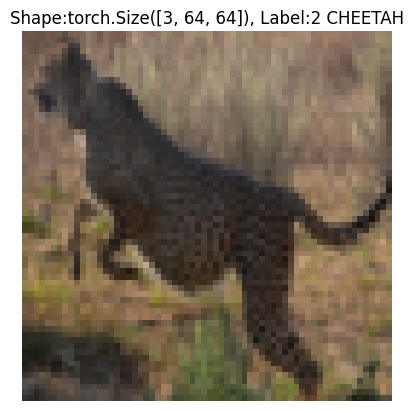

In [6]:
random_image = random.choice(train_data)
plt.imshow(random_image[1].permute(1, 2, 0))
plt.axis(False)
plt.title(f"Shape:{random_image[1].shape}, Label:{random_image[0]} {label_list[random_image[0]]}")

By using DataLoader, we will turn image list to multiple batches to do batch gradient descent later

In [7]:
BATCH_SIZE = 64
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=True)
test_data_loader = DataLoader(dataset=test_data,
                               batch_size=BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=False)

train_data_loader, test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f2010258c40>,
 <torch.utils.data.dataloader.DataLoader at 0x7f201025b2b0>)

In [8]:
len(train_data_loader), len(train_data)

(37, 2339)

In [9]:
label, image = next(iter(train_data_loader))
print(image.shape)
print(label)

torch.Size([64, 3, 64, 64])
tensor([3, 4, 1, 3, 9, 8, 2, 9, 5, 8, 5, 7, 8, 0, 9, 3, 2, 2, 4, 1, 6, 6, 6, 2,
        5, 0, 4, 8, 9, 8, 9, 6, 2, 5, 2, 3, 5, 7, 2, 1, 5, 1, 0, 8, 7, 3, 5, 1,
        2, 4, 4, 9, 6, 5, 8, 4, 4, 1, 3, 3, 5, 5, 9, 5])


## Create ResNet9Model

In [10]:
def conv_block(input_shape, output_shape, pool=False):
  layers = [nn.Conv2d(in_channels=input_shape,
                  out_channels=output_shape,
                  kernel_size=3,
                  padding=1),
            nn.BatchNorm2d(output_shape),
            nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(kernel_size=2))
  return nn.Sequential(*layers)

class ResNet9(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.convblock_1 = conv_block(input_shape, 64) # 64 x 64 x 64
    self.convblock_2 = conv_block(64, 128, pool=True) # 128 x 32 x 32
    self.resblock_1 = nn.Sequential(
        conv_block(128, 128), 
        conv_block(128, 128)
    ) # 128 x 32 x 32

    self.convblock_3 = conv_block(128, 256, pool=True) # 256 x 16 x 16
    self.convblock_4 = conv_block(256, 512, pool=True) # 512 x 8 x 8
    self.resblock_2 = nn.Sequential(
        conv_block(512, 512), 
        conv_block(512, 512)
    ) # 512 x 8 x 8

    self.classifier = nn.Sequential(nn.MaxPool2d(8),
                                    nn.Flatten(),
                                    nn.Dropout(0.25),
                                    nn.Linear(512, output_shape))

  
  def forward(self, x):
    out = self.convblock_2(self.convblock_1(x))
    out = self.resblock_1(out) + out
    out = self.convblock_4(self.convblock_3(out))
    out = self.resblock_2(out) + out
    return self.classifier(out)

In [11]:
model = ResNet9(input_shape=3,
                  output_shape=len(label_list)).to(device)

model

ResNet9(
  (convblock_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convblock_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (resblock_1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

### Test Dummy Data

In [12]:
labels, images = next(iter(train_data_loader))
model(images.to(device))

tensor([[-3.4169e+00, -4.3773e-01,  1.5168e+00, -1.0730e+00, -1.7934e+00,
         -5.3834e-01, -1.0322e+00, -3.7038e+00, -1.3194e+00, -6.6071e-01],
        [-2.4406e+00,  1.3189e-02,  4.2804e-01, -6.4821e-01, -2.4440e+00,
         -1.9816e+00, -9.2144e-01, -1.5332e+00, -4.1712e+00, -2.2855e+00],
        [-3.9737e+00, -1.5263e+00, -4.4385e-01, -3.2496e+00, -2.7644e+00,
          1.8277e+00, -1.8186e+00,  5.1646e-01, -2.9767e+00, -2.2815e-01],
        [-4.5198e+00,  8.0043e-01,  1.2131e+00, -9.7724e-01, -3.8111e-01,
         -2.1970e+00, -2.0463e+00, -1.1940e+00, -1.7343e-01, -9.7024e-01],
        [-4.7701e-01, -6.2303e-01,  8.1040e-01,  3.7579e-02, -8.1816e-01,
         -4.9210e-01, -1.1183e-01, -2.2453e+00, -7.5137e-01,  9.8256e-01],
        [-2.5559e+00, -1.2508e+00,  5.6407e-01,  1.2308e-01, -2.0075e+00,
         -1.2974e+00,  1.0640e-01, -2.4855e+00, -3.9794e-01, -1.2455e+00],
        [-1.0208e+00,  4.3940e-02, -1.0400e+00,  2.8528e+00, -2.7822e+00,
         -1.2604e-01, -1.2639e+0

We will look at the output of each layer by using `torchinfo` library


In [13]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from torchinfo import summary
summary(model, input_size=[64, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 64, 64]          --
│    └─Conv2d: 2-1                       [64, 64, 64, 64]          1,792
│    └─BatchNorm2d: 2-2                  [64, 64, 64, 64]          128
│    └─ReLU: 2-3                         [64, 64, 64, 64]          --
├─Sequential: 1-2                        [64, 128, 32, 32]         --
│    └─Conv2d: 2-4                       [64, 128, 64, 64]         73,856
│    └─BatchNorm2d: 2-5                  [64, 128, 64, 64]         256
│    └─ReLU: 2-6                         [64, 128, 64, 64]         --
│    └─MaxPool2d: 2-7                    [64, 128, 32, 32]         --
├─Sequential: 1-3                        [64, 128, 32, 32]         --
│    └─Sequential: 2-8                   [64, 128, 32, 32]         --
│    │    └─Conv2d: 3-1                  [64, 128, 32, 32]         147,584
│

## Create optimizer and loss function

In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

## Create train steps and test steps function

In [16]:
def train_steps(model, data_loader, optimizer, loss_fn, sched, device=device):
  train_loss, train_acc = 0, 0
  model.train()
  # Loop through data loader
  for batch, (y, X) in enumerate(data_loader):
    y, X = y.to(device), X.to(device)
    
    y_pred = model(X)
    
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    if batch != 0:
      sched.step()
    
    loss.backward()
    
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)
  
  # Average statistic per batch
  train_acc /= len(data_loader)
  train_loss /= len(data_loader)
  return train_loss, train_acc

In [17]:
def test_steps(model, data_loader, loss_fn, device=device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch, (y, X) in enumerate(data_loader):
      y, X = y.to(device), X.to(device)
      
      y_pred = model(X)
      
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      test_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (test_pred_class == y).sum().item()/len(test_pred_class)
  
  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  return test_loss, test_acc


## Train model by combining train step and test step

In [18]:
def train(epochs, model, loss_fn, optimizer, train_data_loader, test_data_loader):
  start_time = default_timer()
  result = {
    "train loss": [],
    "test loss": [],
    "train acc": [],
    "test acc": [],
    "time": 0,
  }
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.005, epochs=epochs, 
                                                steps_per_epoch=len(train_data_loader))
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_steps(model, train_data_loader, optimizer, loss_fn, sched)
    test_loss, test_acc = test_steps(model, test_data_loader, loss_fn)
    if epoch % 5 == 0:
      print(f"Epoch: {epoch} | Train Loss: {train_loss}, Train acc: {train_acc} | Test Loss: {test_loss}, Test acc: {test_acc}")
    result["train loss"].append(train_loss)
    result["test loss"].append(test_loss)
    result["test acc"].append(test_acc)
    result["train acc"].append(train_acc)
  end_time = default_timer()
  result["time"] = end_time - start_time
  return result
    

In [19]:
EPOCHS = 50
train_result = train(EPOCHS, model, loss_fn, optimizer, train_data_loader, test_data_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 2.2482287046071647, Train acc: 0.2844594594594595 | Test Loss: 6.150024890899658, Test acc: 0.078125
Epoch: 5 | Train Loss: 0.9142869582047334, Train acc: 0.6743605212355213 | Test Loss: 2.9431097507476807, Test acc: 0.4166666666666667
Epoch: 10 | Train Loss: 0.6860850695017222, Train acc: 0.7734676640926641 | Test Loss: 1.3864172399044037, Test acc: 0.6467013888888888
Epoch: 15 | Train Loss: 0.3322202043758856, Train acc: 0.8866192084942084 | Test Loss: 1.8144797682762146, Test acc: 0.5659722222222222
Epoch: 20 | Train Loss: 0.16032902896404266, Train acc: 0.9453185328185327 | Test Loss: 0.7381983399391174, Test acc: 0.7925347222222222
Epoch: 25 | Train Loss: 0.06739591477388465, Train acc: 0.9755067567567568 | Test Loss: 0.7436662763357162, Test acc: 0.7881944444444444
Epoch: 30 | Train Loss: 0.05278521333821118, Train acc: 0.9861365830115829 | Test Loss: 0.4971846640110016, Test acc: 0.8385416666666667
Epoch: 35 | Train Loss: 0.004491012451408834, Train acc: 0

In [20]:
def make_predictions(model, data, device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      #add batch size to dimension
      sample = torch.unsqueeze(sample, dim=0).to(device)
      
      pred_logit = model(sample)
       
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())
  
  return torch.stack(pred_probs)

## Evaluate our model

In [21]:
train_loss, train_acc, test_loss, test_acc = train_result["train loss"][-1], train_result["train acc"][-1], train_result["test loss"][-1], train_result["test acc"][-1]
print(f"Train Loss: {train_loss}, Train acc: {train_acc} | Test Loss: {test_loss}, Test acc: {test_acc}")

Train Loss: 0.0010126893028771864, Train acc: 1.0 | Test Loss: 0.2884472534060478, Test acc: 0.9210069444444444


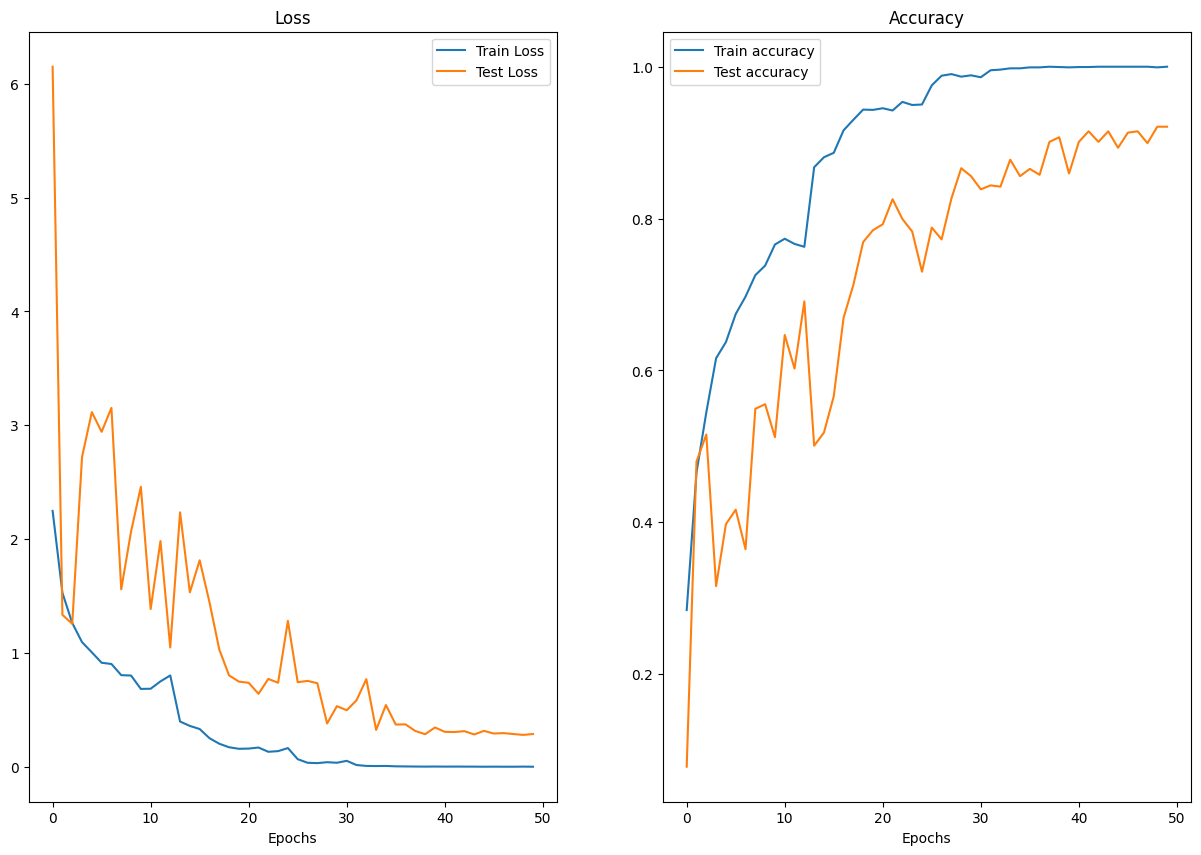

In [22]:
plt.figure(figsize=(15, 10))
# Plot loss function
epochs = range(len(train_result["train loss"]))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_result["train loss"], label="Train Loss")
plt.plot(epochs, train_result["test loss"], label="Test Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_result["train acc"], label="Train accuracy")
plt.plot(epochs, train_result["test acc"], label="Test accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

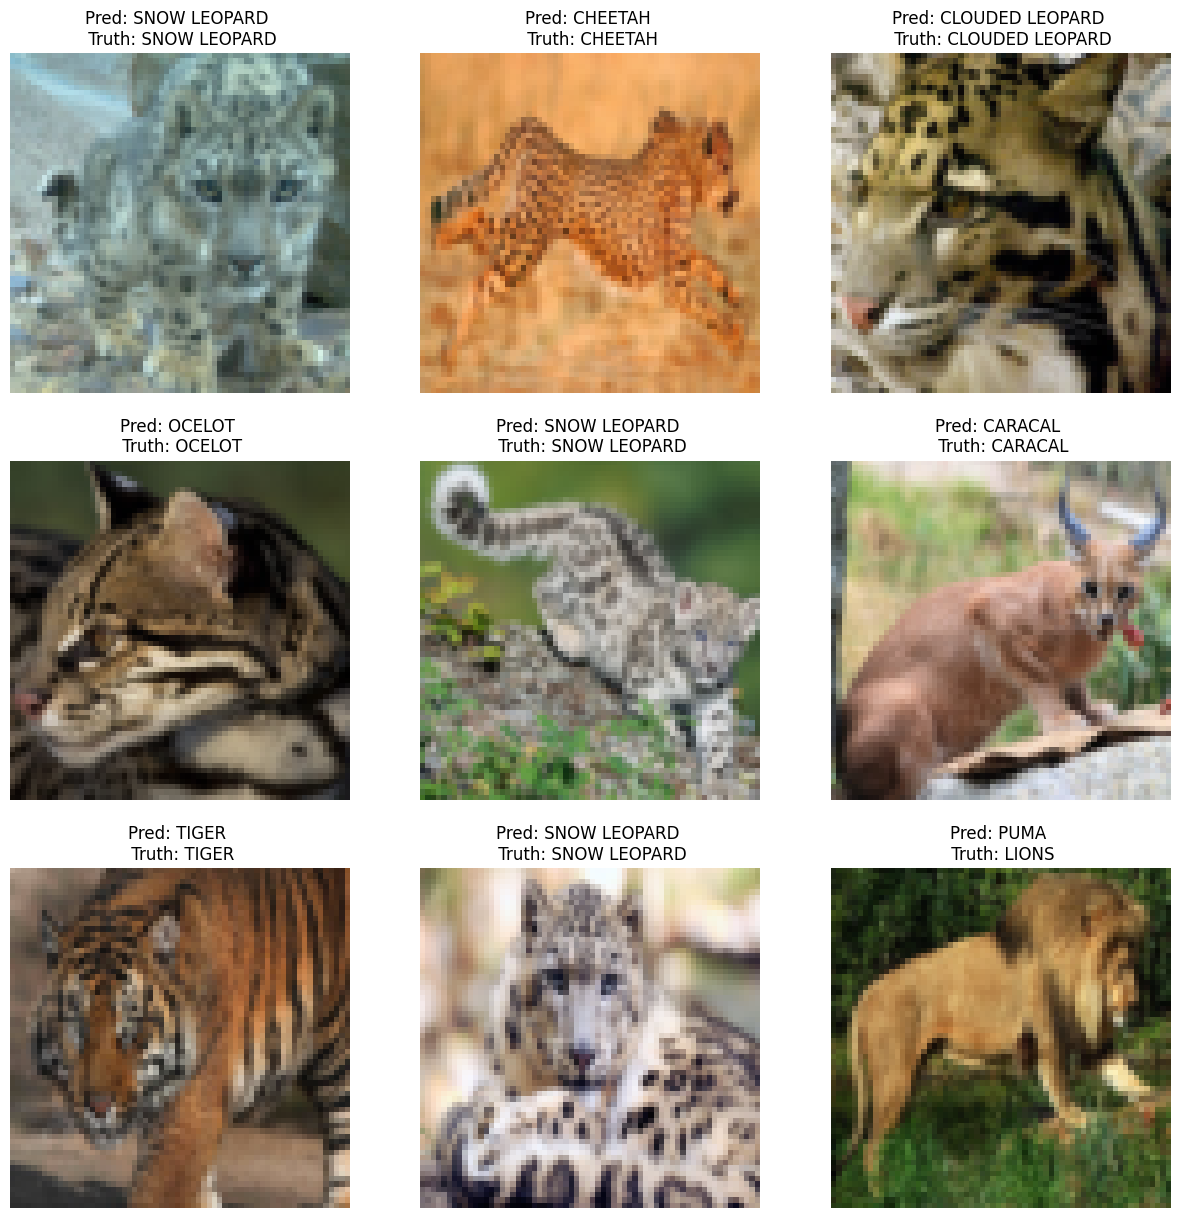

In [23]:
test_samples = []
test_labels = []
for label, sample in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)


pred_probs = make_predictions(model=model,
                              data=test_samples,
                              device=device)

pred_classes = pred_probs.argmax(dim=1)
plt.figure(figsize=(15, 15))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i + 1)
  plt.imshow(sample.permute(1, 2, 0))
  plt.axis(False)
  pred_label = label_list[pred_classes[i].item()]
  truth_label = label_list[test_labels[i]]
  title_text = f"Pred: {pred_label} \n Truth: {truth_label}"
  plt.title(title_text)

  0%|          | 0/2 [00:00<?, ?it/s]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.4 MB/s eta 0:00:00
0.14.0


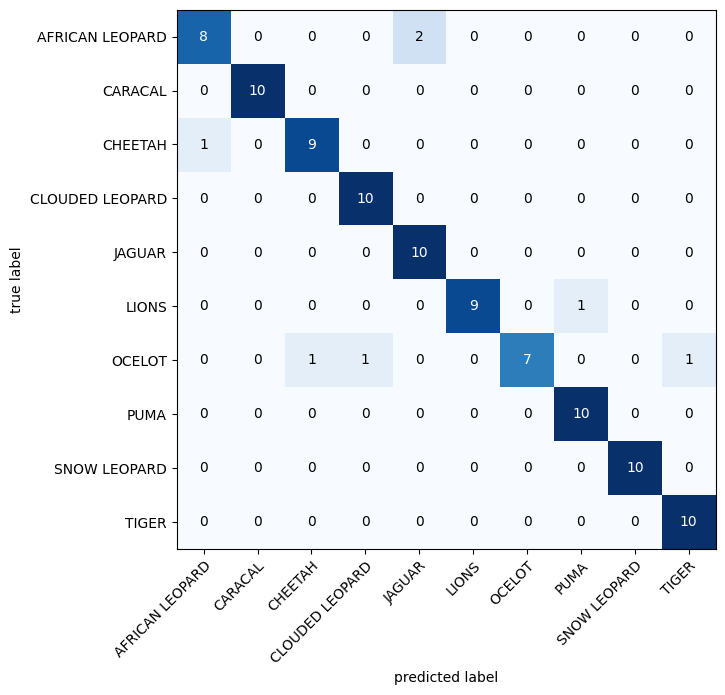

In [24]:
y_preds = []
y_correct = []
model.eval()
with torch.inference_mode():
  for y, X in tqdm(test_data_loader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_labels = y_logit.squeeze().argmax(dim=1)
    y_preds.append(y_labels.cpu())
    y_correct.append(y.cpu())
  
y_pred_tensor = torch.cat(y_preds)
y_correct_tensor = torch.cat(y_correct)

try:
  import mlxtend, torchmetrics
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "Error"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend

print(mlxtend.__version__)

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(label_list), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,target=y_correct_tensor)
confmat_tensor
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=label_list,
    figsize=(10,7)
)